In [1]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeAthensV2

import pennylane as qml

import matplotlib.pyplot as plt

from random import shuffle
from tqdm import tqdm

In [2]:
import sys
sys.path.append('../')

In [3]:
from circuits.generate_circuits import custom_ghz
from circuits.modify_circuits import append_pqc_to_quantum_circuit, get_str_circuit_for_model, get_unitary_for_model_pennylane
from circuits.pqc_circuits import pennylane_PQC_RZRXRZ_CX_unique, qiskit_PQC_RZRXRZ_CX_unique

from simulator.simulate import get_ideal_data_state, get_ideal_data_superpos, run_sampler_pennylane
from models.pennylane_models import SimplePennylaneQuantumStateModel
from models.noise_models import BitPhaseFlipNoise
from circuits.generate_circuits import GetGHZCircuitsForModel
from utils.loss_functions import QuantumFidelityLoss

In [4]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    torch_device = torch.device("cpu")
    aer_device = "CPU"
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    torch_device = torch.device("cuda")
    aer_device = "GPU"
else:
    print('Torch running on CPU')
    torch_device = torch.device("cpu")
    aer_device = "CPU"


Torch running on Apple GPU


In [5]:
NUM_SHOTS = 2**10
NUM_QUBITS = 8
H_ON = 5
INPUT_BITS = '10110001'
EPOCHS = 5
# fakeVigo2_backend = FakeVigoV2()
# fakeAthensV2_backend = FakeAthensV2()

ideal_sim = AerSimulator()
# noisy_sim = AerSimulator().from_backend(fakeAthensV2_backend)
pqc_arch = pennylane_PQC_RZRXRZ_CX_unique

In [6]:
noise_model = BitPhaseFlipNoise()

pqc_model = SimplePennylaneQuantumStateModel(
    num_qubits= NUM_QUBITS, num_params=NUM_QUBITS*3, pqc_arch_func=pqc_arch,   
    )

ghz_circuit_gen = GetGHZCircuitsForModel(
    num_qubits= NUM_QUBITS, hammard_on=H_ON, noise=noise_model
    )



In [7]:
optimizer = torch.optim.AdamW(pqc_model.parameters(), lr=0.0005)
loss_fn = QuantumFidelityLoss()
# loss_fn = nn.MSELoss()

In [8]:
ideal_data = get_ideal_data_state(NUM_QUBITS, num_vals=int(10000))
# get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=1000, get_soft=False)
print(len(ideal_data[10][1]))

Generating Ideal Data: 100%|██████████| 10000/10000 [00:07<00:00, 1385.24it/s]

256


In [9]:
param_list_epoch = []  # Stores parameter evolution across epochs
loss_list_epoch = []   # Stores mean loss per epoch

enable_debug_logs = True  # Set False to suppress grad/param printouts
lambda_reg = 0.01         # Regularization weight

for epoch in range(EPOCHS):
    print(f'\n Starting Epoch {epoch+1}')
    pqc_model.train()
    epoch_loss_list = []
    epoch_param_snapshots = []

    shuffle(ideal_data)
    data_iterator = tqdm(ideal_data)

    for step, (params, ideal) in enumerate(data_iterator):
        optimizer.zero_grad()

        circuit = ghz_circuit_gen.get_noisy_model_circuit_params(params)
        measured = pqc_model(circuit=circuit)

        ideal = ideal.to(torch_device)
        measured = measured.to(torch_device)

        # print(ideal)
        # print(measured)

        # Compute fidelity loss
        # print(ideal)
        # print(measured)
        loss = loss_fn(ideal, measured)

        # Add optional regularization to keep angles from zeroing out

        loss.backward()
        optimizer.step()

        raw_param_values = pqc_model.raw_params.detach().cpu().numpy()
        epoch_param_snapshots.append(raw_param_values)
        epoch_loss_list.append(loss.item())

        data_iterator.set_postfix_str(f"Loss: {loss.item():.4e}")

        # Optional: print debug stats
        if enable_debug_logs and step == 0:
            grad_norm = pqc_model.raw_params.grad.norm().item()
            # bounded = pqc_model.raw_params.detach().cpu().numpy()
            print(f"\tStep {step}, grad norm: {grad_norm:.4e}")
            print(f"\tRaw param range: [{raw_param_values.min():.3f}, {raw_param_values.max():.3f}]")
            # print(f"\tBounded param range: [{bounded.min():.3f}, {bounded.max():.3f}]")

# Optional: print debug stats
        # if enable_debug_logs and step == len(data_iterator) - 1:
        #     print(circuit.draw())
        #     print(measured)
        #     print(ideal)
        #     print(loss)

    # Log epoch summary
    avg_loss = np.mean(epoch_loss_list)
    loss_list_epoch.append(avg_loss)
    param_list_epoch.extend(np.array(epoch_param_snapshots))

    print(f"Epoch {epoch+1} complete: avg loss = {avg_loss:.4e}")

        


 Starting Epoch 1


  0%|          | 3/10000 [00:00<07:21, 22.62it/s, Loss: 9.9988e-01]

	Step 0, grad norm: 1.7378e-03
	Raw param range: [-18.532, 16.606]


100%|██████████| 10000/10000 [07:22<00:00, 22.60it/s, Loss: 9.8385e-01]


Epoch 1 complete: avg loss = 9.8961e-01

 Starting Epoch 2


  0%|          | 2/10000 [00:00<08:49, 18.88it/s, Loss: 9.9819e-01]

	Step 0, grad norm: 8.9659e-03
	Raw param range: [-17.408, 15.214]


100%|██████████| 10000/10000 [07:21<00:00, 22.63it/s, Loss: 9.8370e-01]


Epoch 2 complete: avg loss = 9.8662e-01

 Starting Epoch 3


  0%|          | 3/10000 [00:00<07:18, 22.79it/s, Loss: 9.9543e-01]

	Step 0, grad norm: 2.7308e-02
	Raw param range: [-16.765, 14.802]


100%|██████████| 10000/10000 [07:25<00:00, 22.47it/s, Loss: 9.5836e-01]


Epoch 3 complete: avg loss = 9.8550e-01

 Starting Epoch 4


  0%|          | 3/10000 [00:00<07:14, 23.00it/s, Loss: 9.9438e-01]

	Step 0, grad norm: 3.8834e-02
	Raw param range: [-16.551, 14.439]


100%|██████████| 10000/10000 [07:13<00:00, 23.06it/s, Loss: 9.4551e-01]


Epoch 4 complete: avg loss = 9.8560e-01

 Starting Epoch 5


  0%|          | 3/10000 [00:00<07:04, 23.54it/s, Loss: 9.9917e-01]

	Step 0, grad norm: 2.0230e-02
	Raw param range: [-16.489, 14.059]


100%|██████████| 10000/10000 [07:11<00:00, 23.20it/s, Loss: 9.9704e-01]

Epoch 5 complete: avg loss = 9.8587e-01


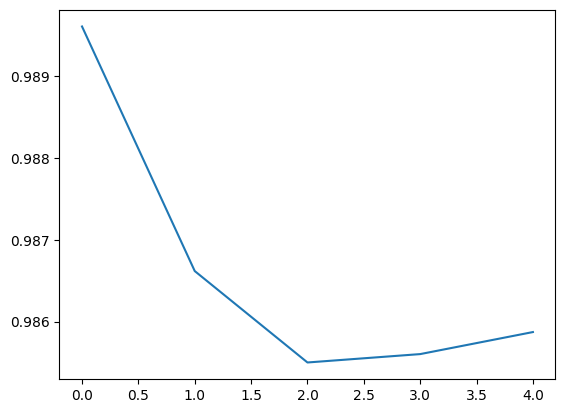

In [10]:
plt.plot(range(EPOCHS), loss_list_epoch)
plt.show()

In [11]:
print(pqc_model.raw_params)

Parameter containing:
tensor([ 13.6310,  -0.0996,   0.0575,  13.2517, -16.4518,  -0.5277,   0.9661,
         10.2634,  -2.9047,  12.5703,   3.8281,  11.6694,  -1.5162,  -4.0233,
          0.2317,   4.1895,  -7.6806,  -7.6130,  -1.6326,   1.4809,   3.2500,
         -6.2967,  -4.5707,  -6.1889], requires_grad=True)


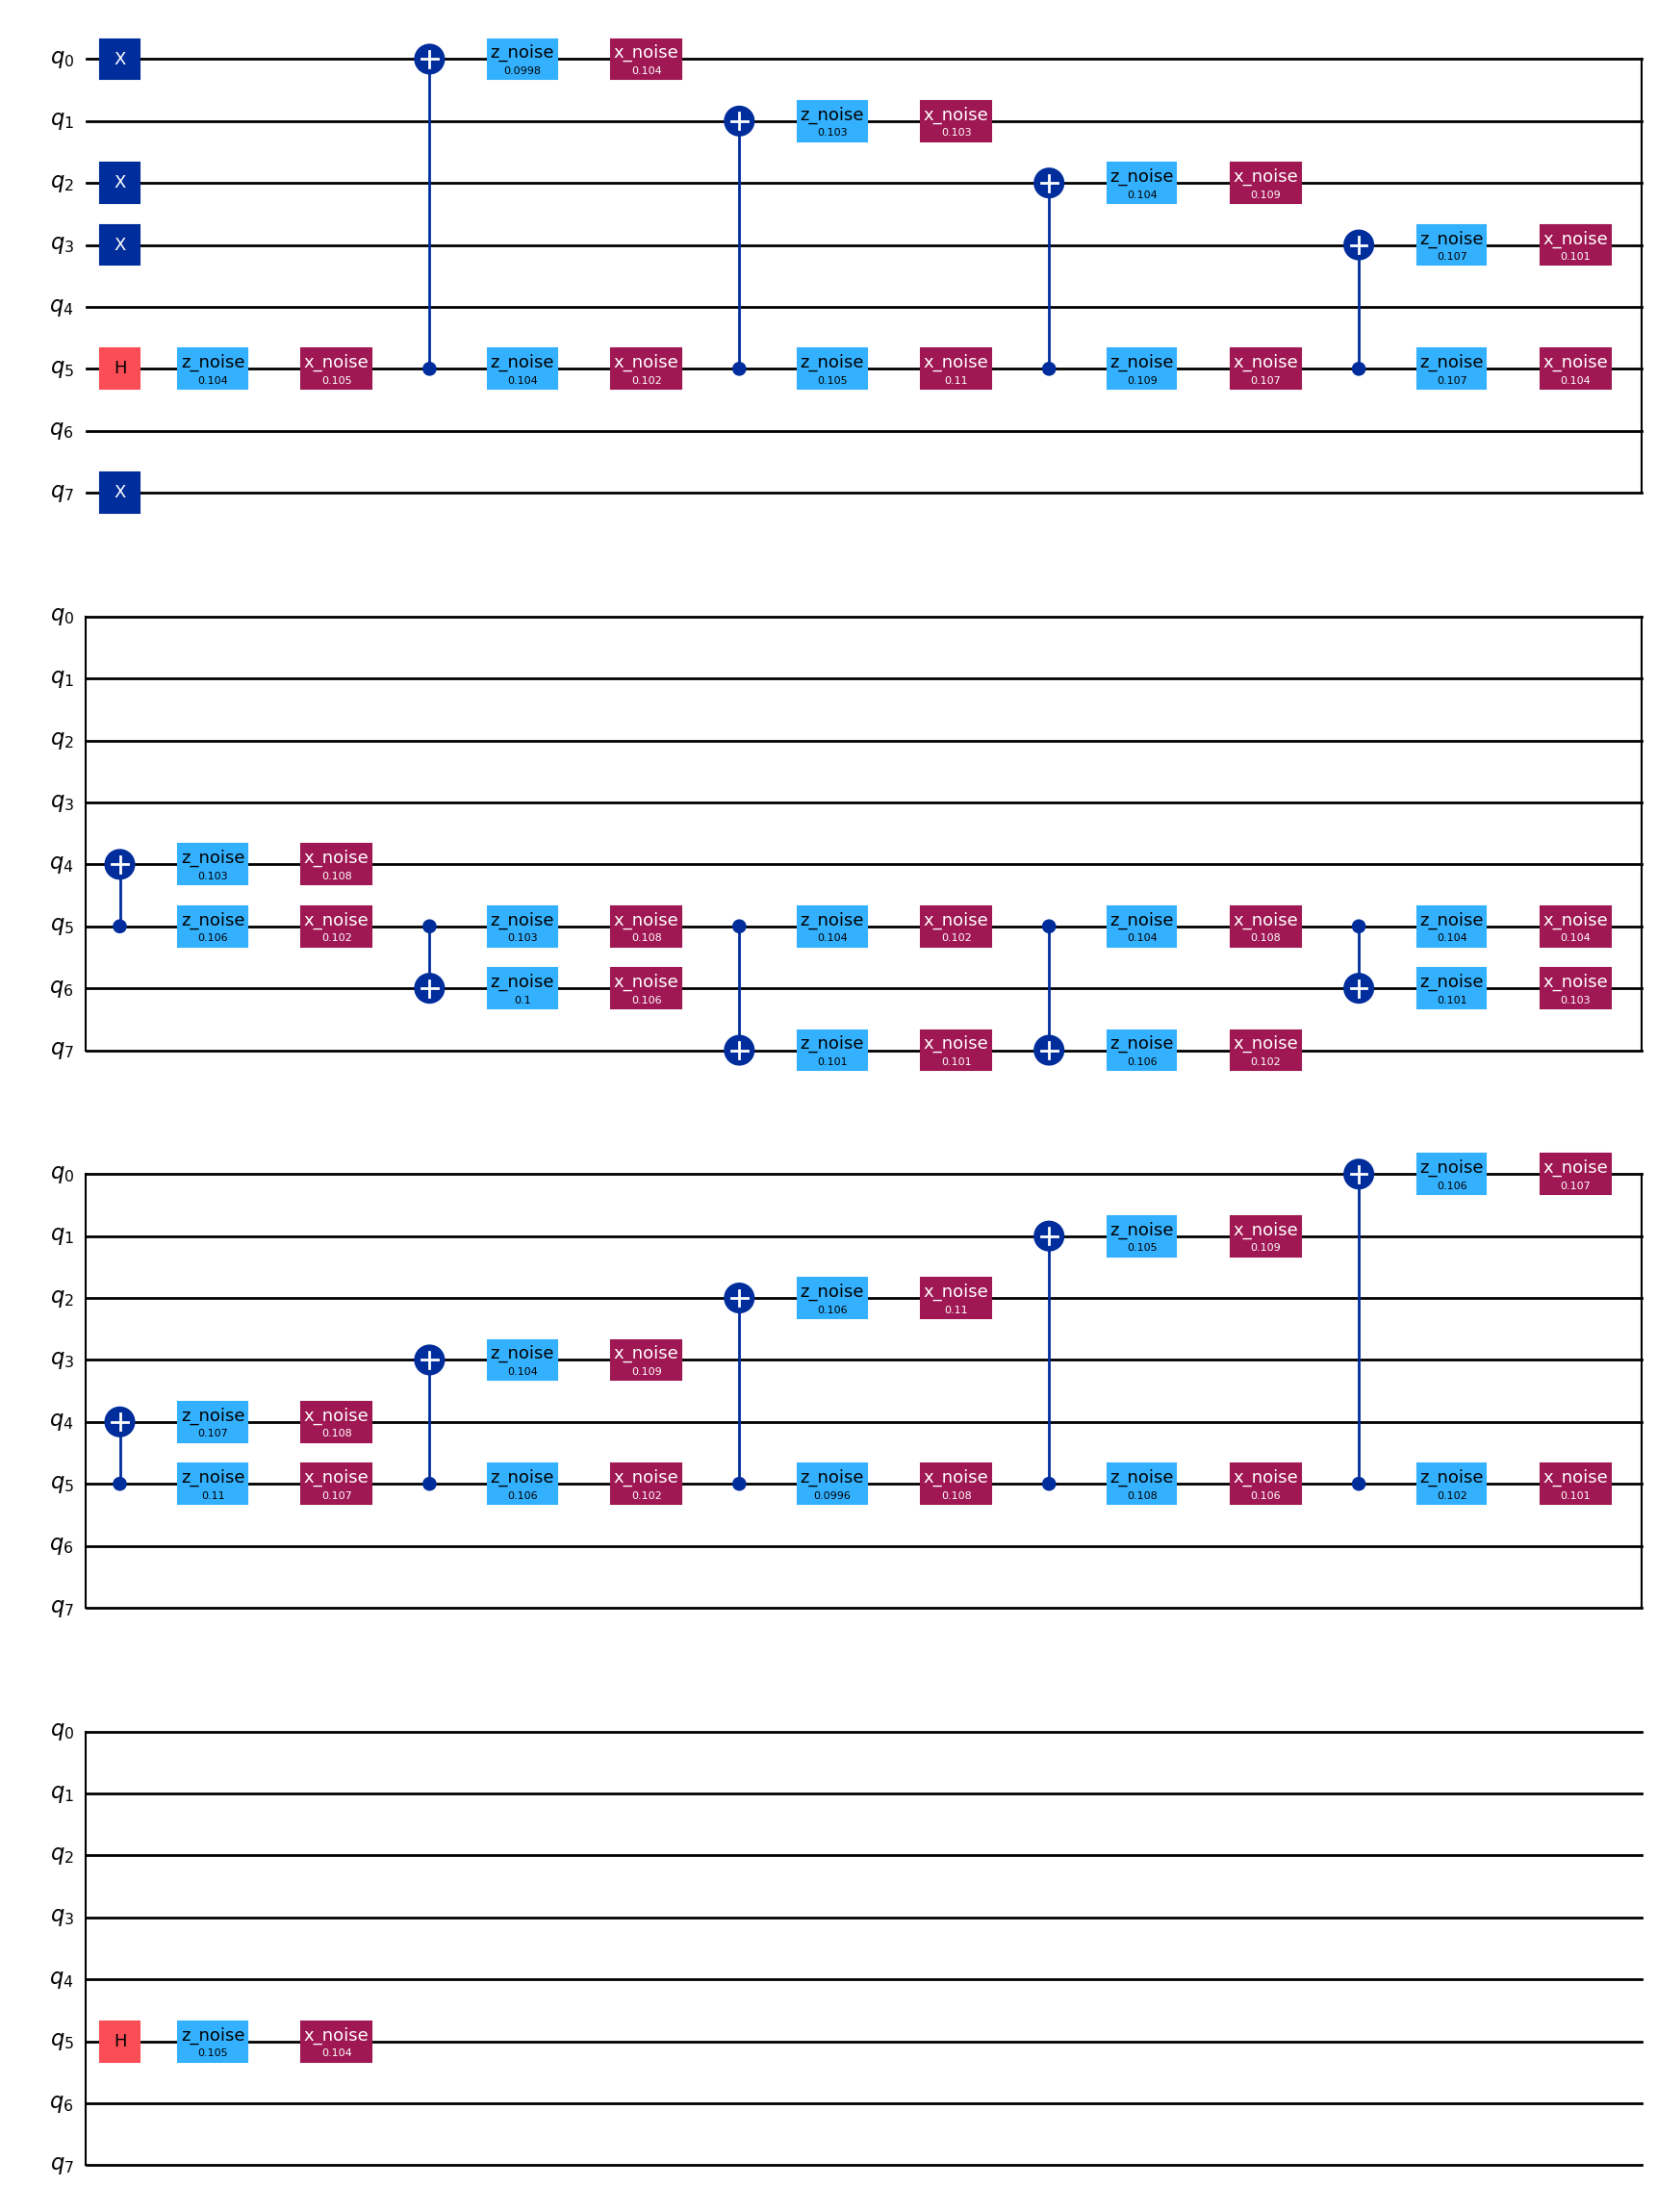

In [12]:
noisy_model_circ = ghz_circuit_gen.get_noisy_model_circuit_bitstring(INPUT_BITS)
noisy_model_circ.draw('mpl')

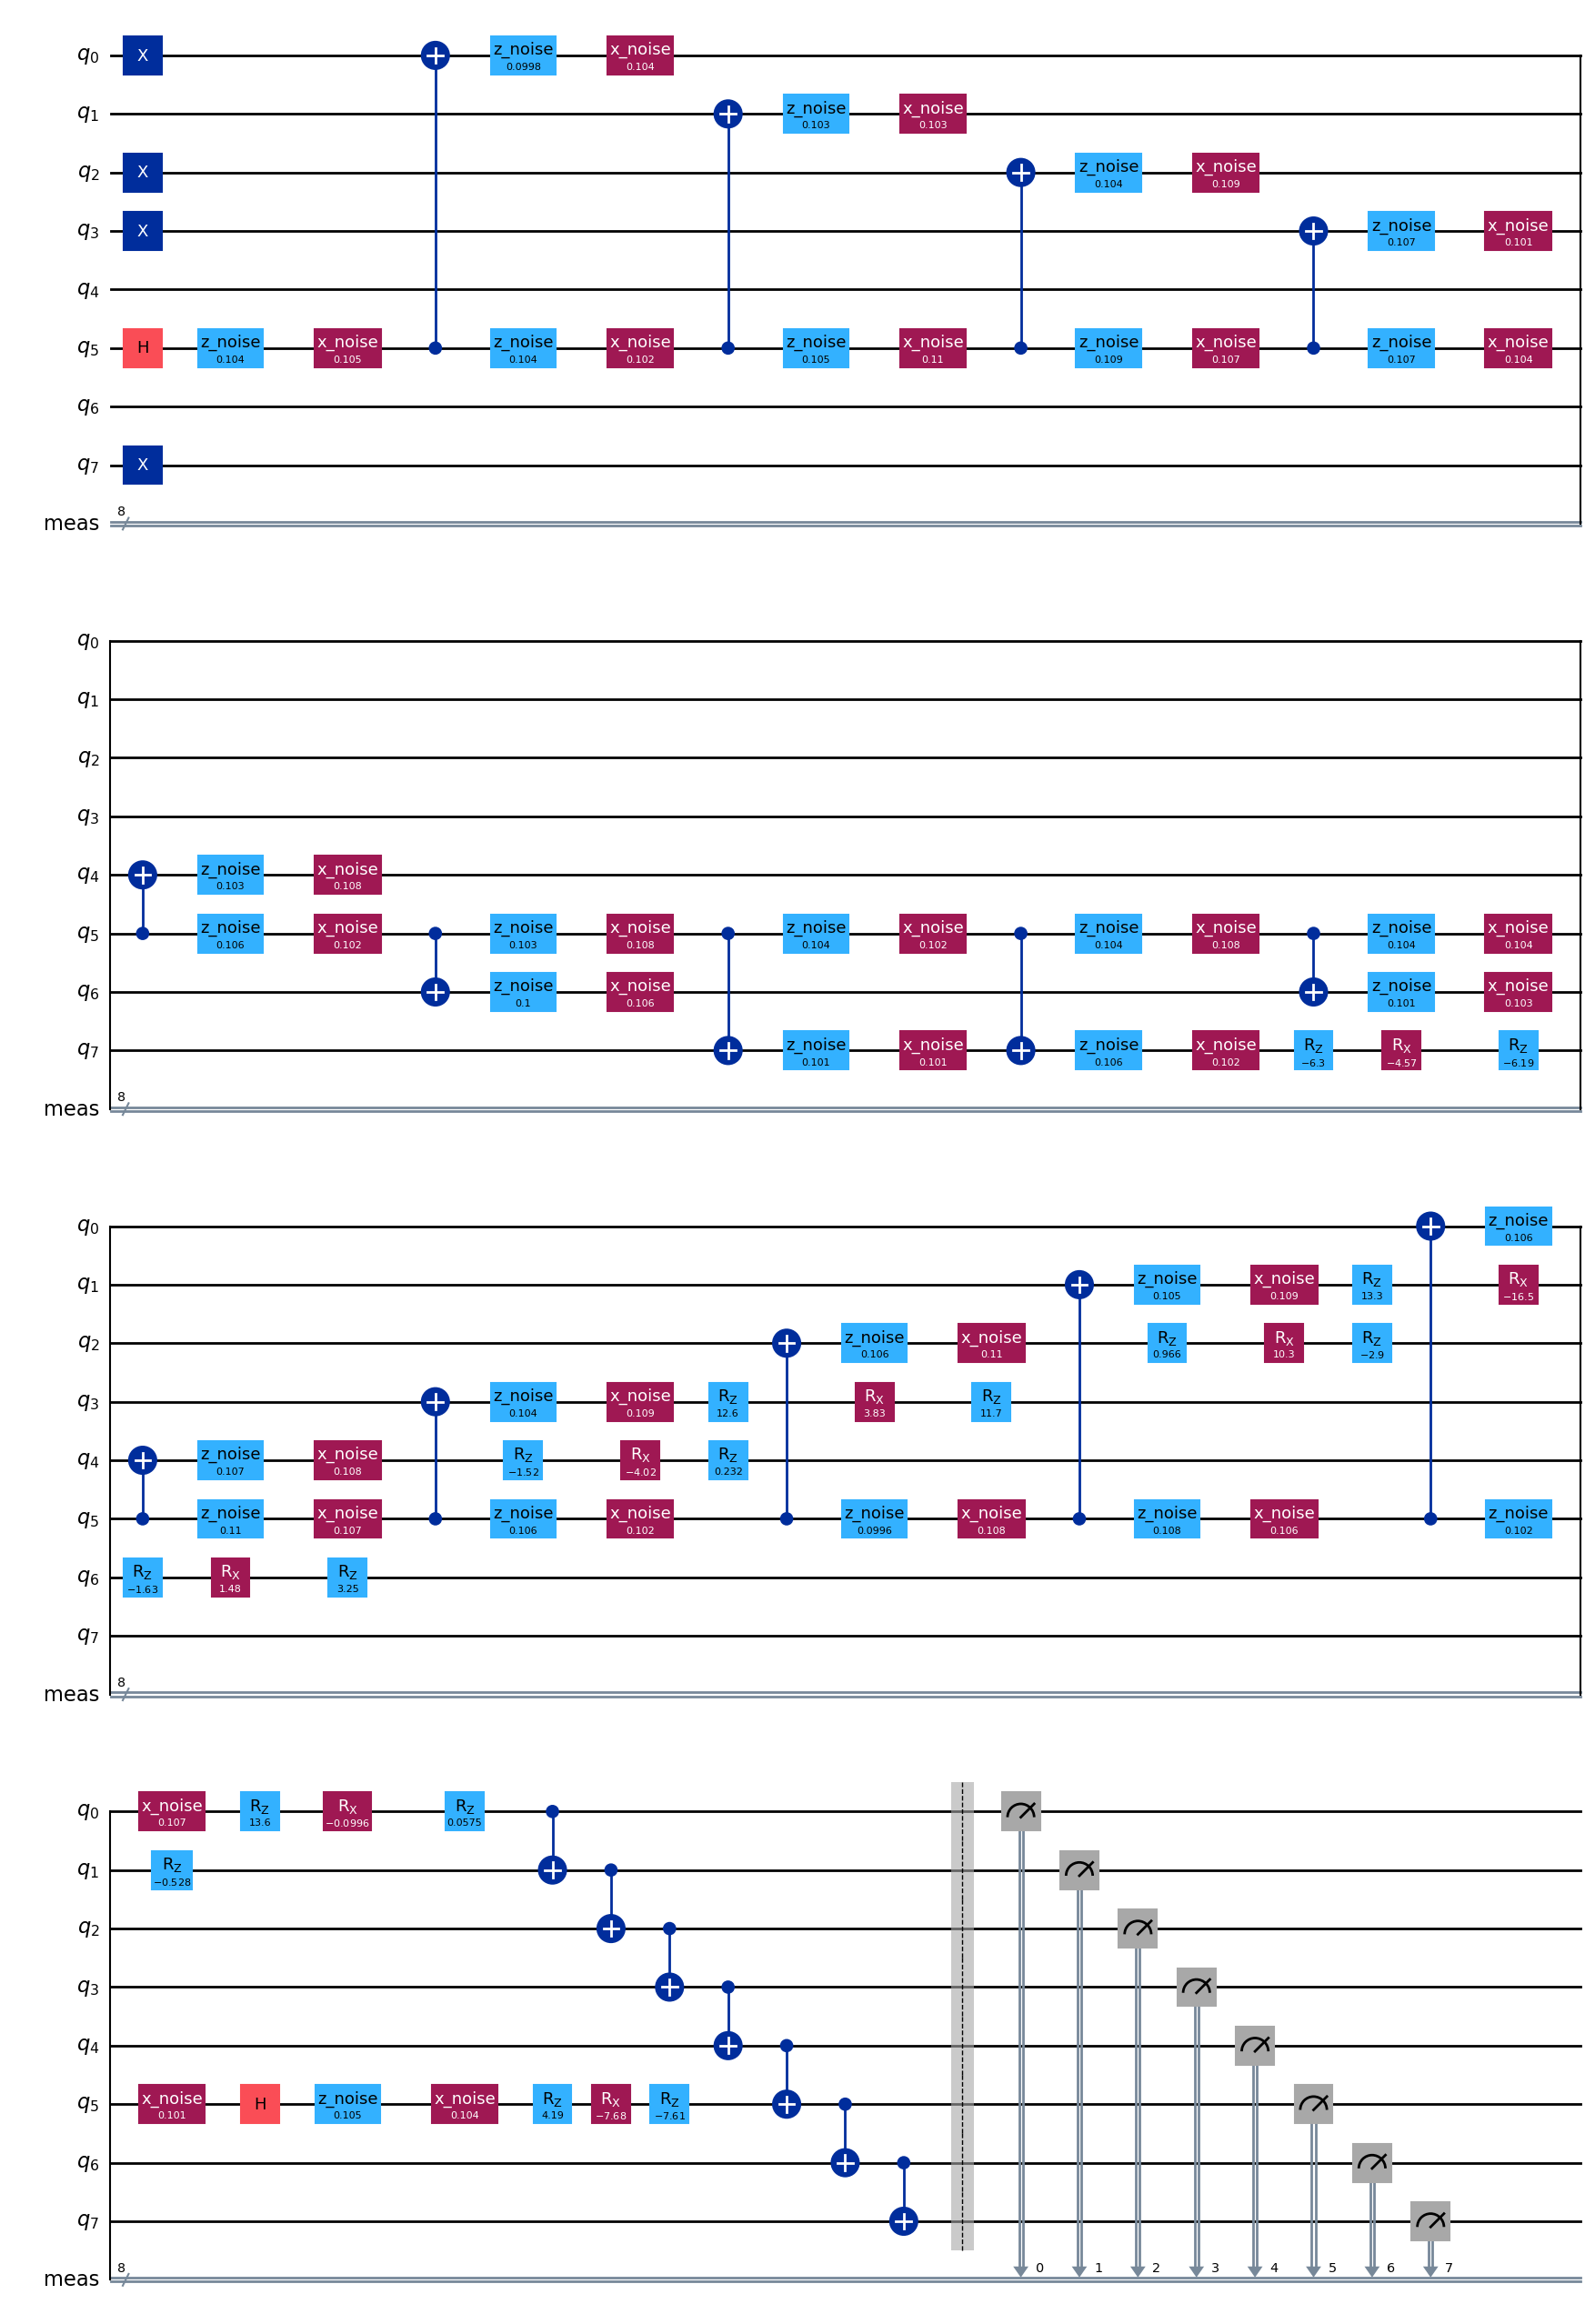

In [13]:
noisy_model_circ_pqc = append_pqc_to_quantum_circuit(noisy_model_circ, pqc_model.raw_params, qiskit_PQC_RZRXRZ_CX_unique)
noisy_model_circ_pqc.draw('mpl')

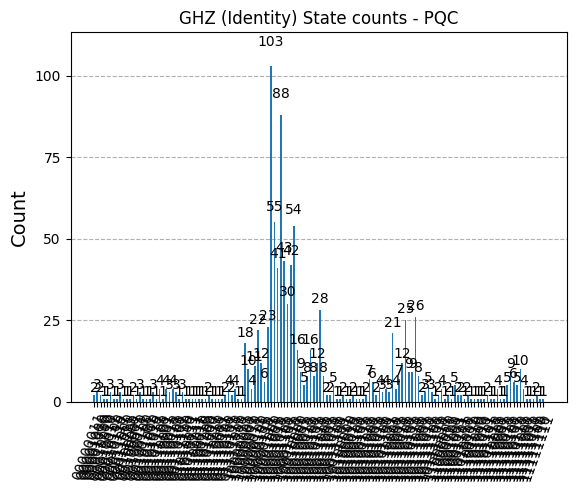

In [14]:
# transpiled_circ = transpile(noisy_model_circ_pqc, ideal_sim)
# result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
# counts = result.get_counts(transpiled_circ)

counts = run_sampler_pennylane(noisy_model_circ_pqc)

plot_histogram(counts, title='GHZ (Identity) State counts - PQC')

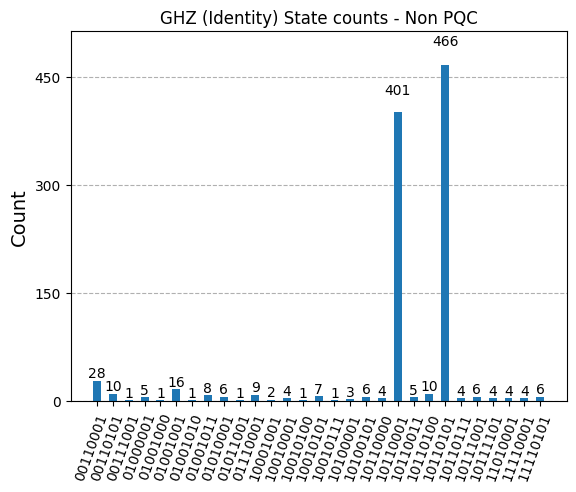

In [15]:
# transpiled_circ = transpile(noisy_model_circ.measure_all(inplace=False), ideal_sim)
# result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
# counts = result.get_counts(transpiled_circ)


counts = run_sampler_pennylane(noisy_model_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - Non PQC')

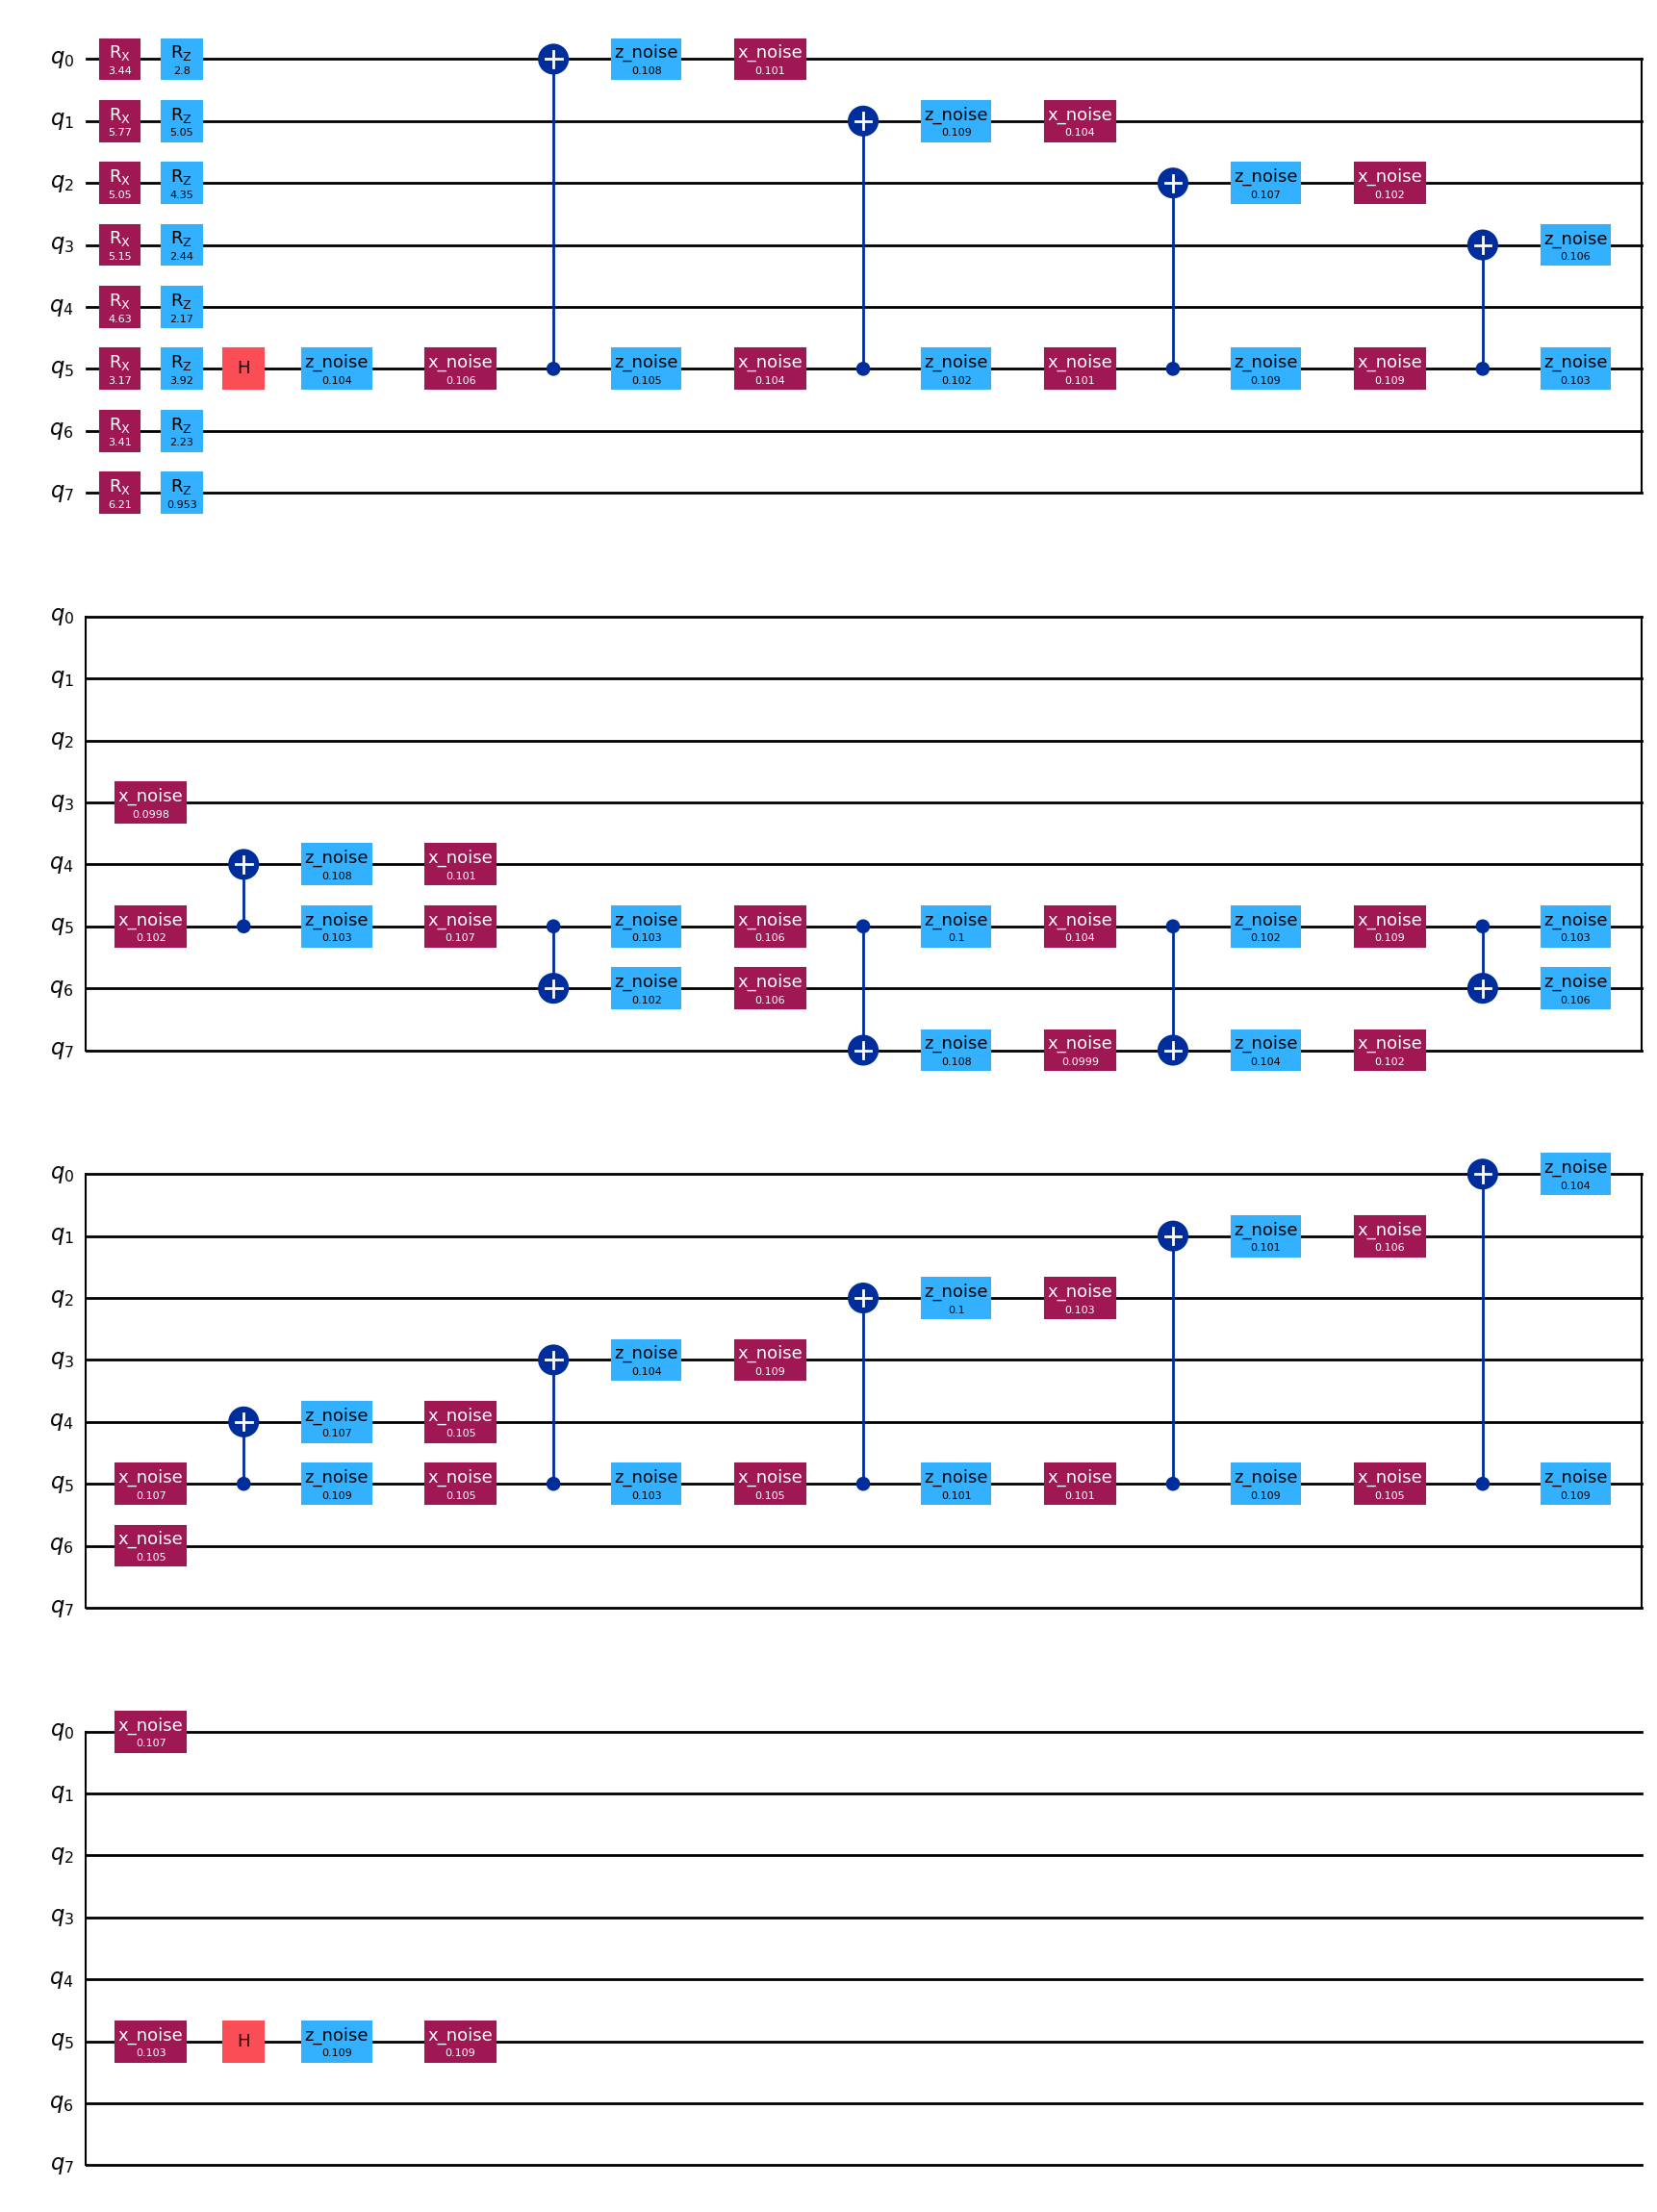

In [16]:
circuit.draw('mpl')

In [18]:
from qiskit.quantum_info import Statevector

def counts_to_probs(counts: torch.Tensor) -> torch.Tensor:
    """Convert integer counts to a normalized probability vector."""
    return counts.float() / counts.sum()

def state_fidelity(psi: torch.Tensor, phi: torch.Tensor) -> torch.Tensor:
    """
    Compute fidelity F = |⟨ψ|φ⟩|² between two normalized state vectors.

    Args:
        psi (torch.Tensor): Complex tensor of shape (2**n,) representing |ψ⟩
        phi (torch.Tensor): Complex tensor of shape (2**n,) representing |φ⟩

    Returns:
        torch.Tensor: Real-valued scalar fidelity
    """
    # Optional: normalize if needed
    psi = psi / torch.linalg.norm(psi)
    phi = phi / torch.linalg.norm(phi)

    overlap = torch.dot(torch.conj(psi), phi)
    return torch.abs(overlap) ** 2

fid_noisy = []
fid_noisy_pqc = []

pqc_params = pqc_model.raw_params

ideal_data_test = get_ideal_data_superpos(NUM_QUBITS, num_vals=20, statevector=True)

for param, ideal in ideal_data_test:
    noisy_circ = ghz_circuit_gen.get_noisy_model_circuit_params(params=param)
    noisy_circ_pqc = append_pqc_to_quantum_circuit(noisy_circ, pqc_params, qiskit_PQC_RZRXRZ_CX_unique)

    noi_out_st = torch.tensor(Statevector.from_instruction(noisy_circ.remove_final_measurements(inplace=False)).data)
    npqc_out_st = torch.tensor(Statevector.from_instruction(noisy_circ_pqc.remove_final_measurements(inplace=False)).data)
    
    

    fid_i_n = state_fidelity(ideal, noi_out_st)
    fid_i_ne = state_fidelity(ideal, npqc_out_st)

    fid_noisy.append(fid_i_n)
    fid_noisy_pqc.append(fid_i_ne)

    

Generating Ideal Data: 100%|██████████| 20/20 [00:00<00:00, 2348.04it/s]


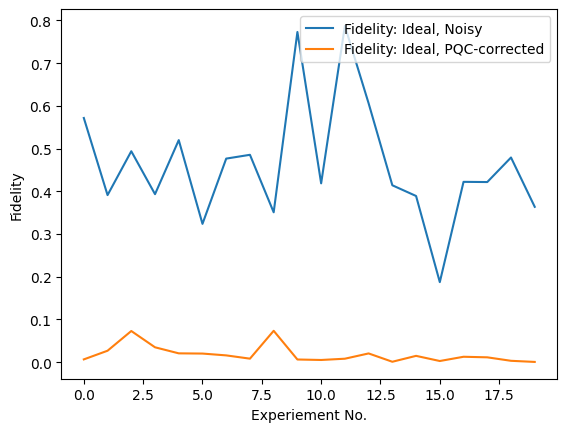

In [19]:
x = range(len(ideal_data_test))

# option 1 ─ two explicit calls
plt.plot(x, fid_noisy,      label='Fidelity: Ideal, Noisy')
plt.plot(x, fid_noisy_pqc,  label='Fidelity: Ideal, PQC-corrected')
plt.xlabel('Experiement No.')          # optional cosmetics
plt.ylabel('Fidelity')
plt.legend()                      # shows the two labels
plt.show()

In [20]:
print(f"Avg Fidelity of noisy circuit: {np.mean(fid_noisy)}, Average Fidelity of noisy circ with PQC: {np.mean(fid_noisy_pqc)}")

Avg Fidelity of noisy circuit: 0.46348235607296245, Average Fidelity of noisy circ with PQC: 0.018295093170524548


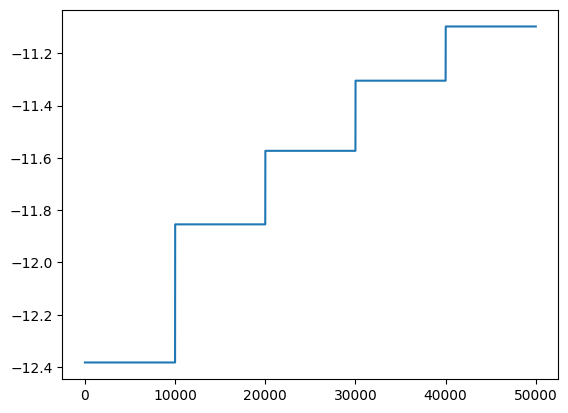

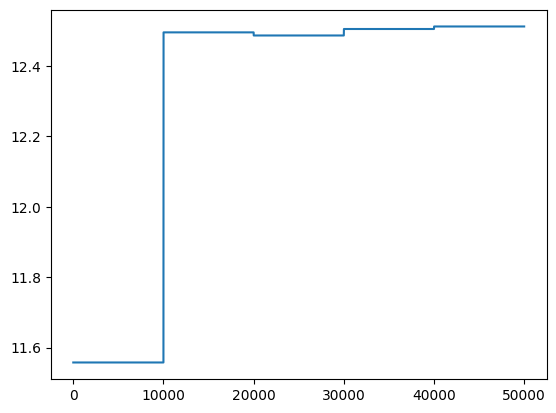

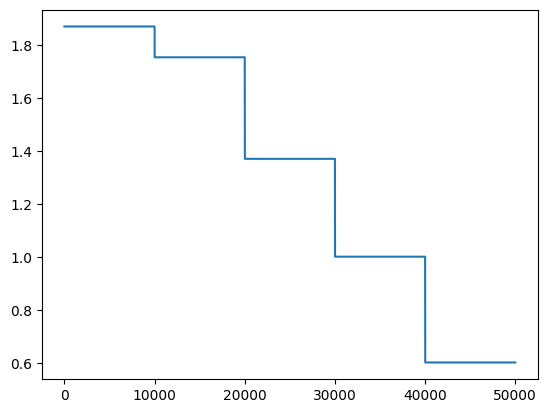

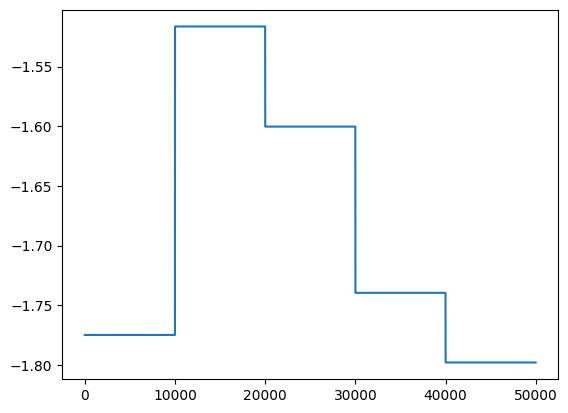

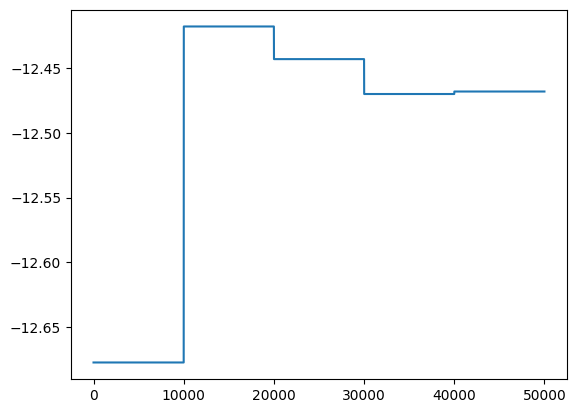

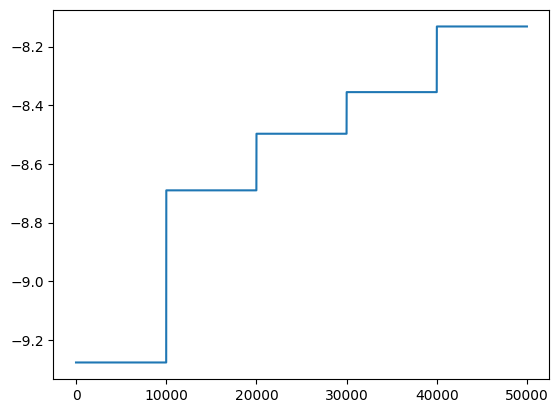

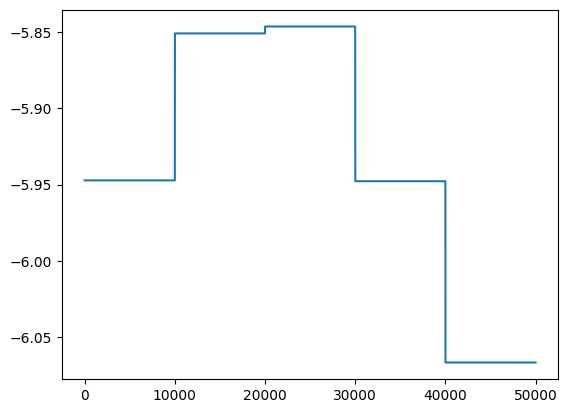

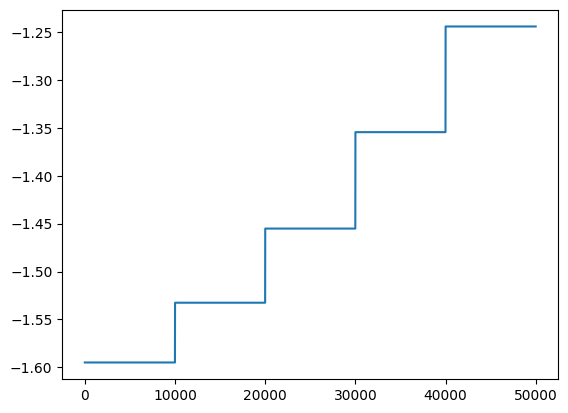

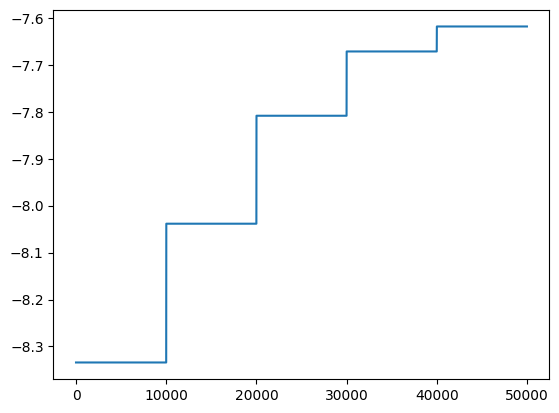

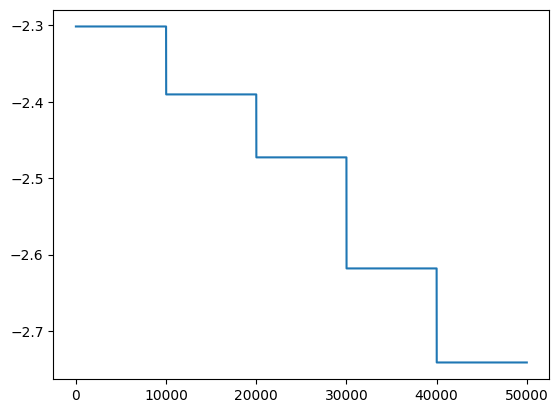

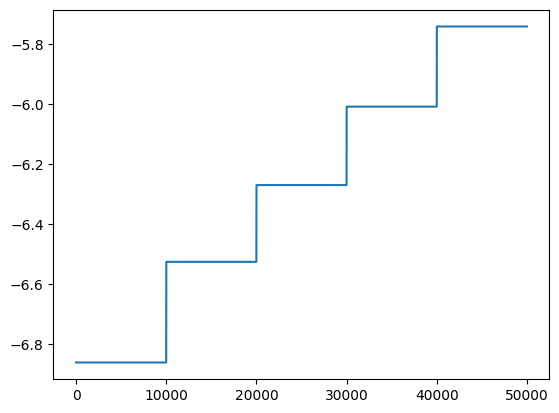

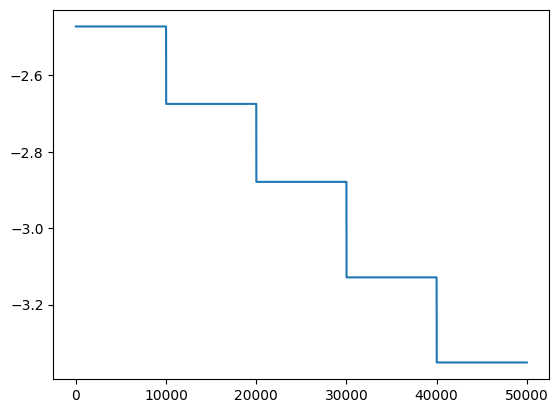

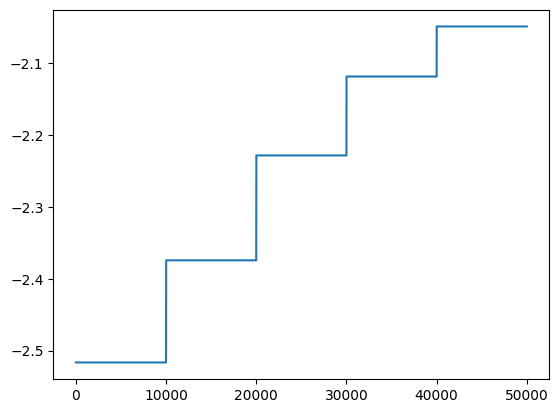

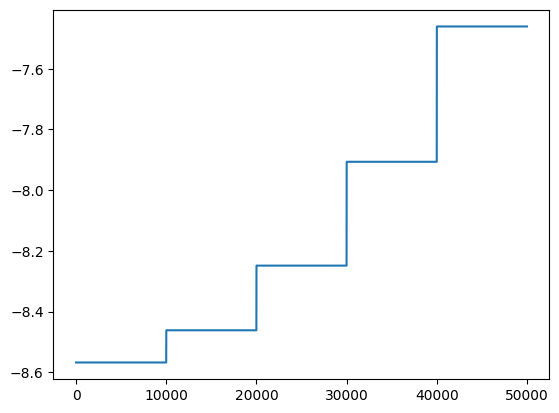

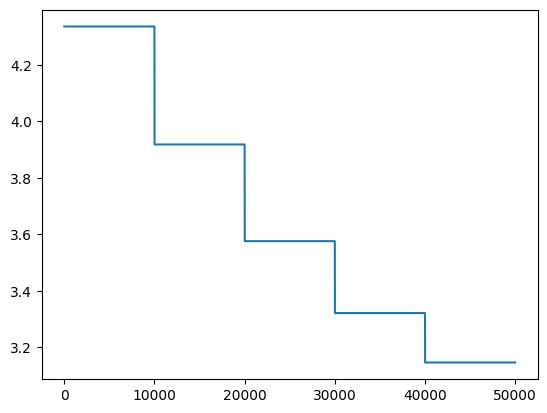

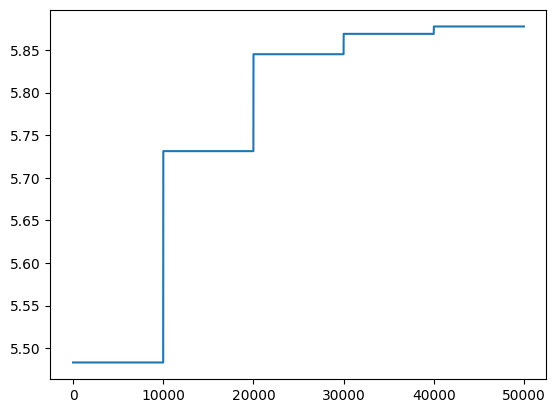

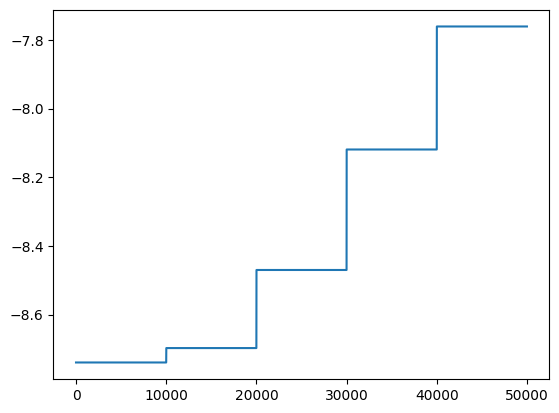

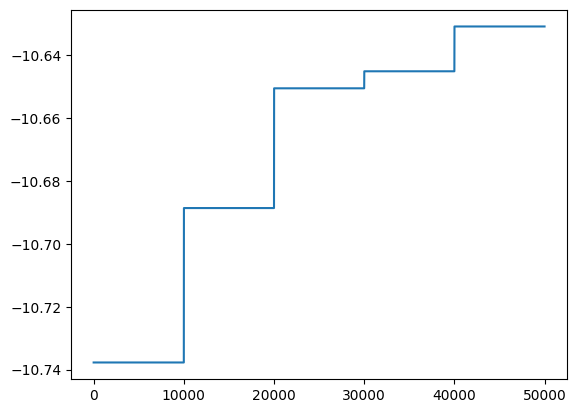

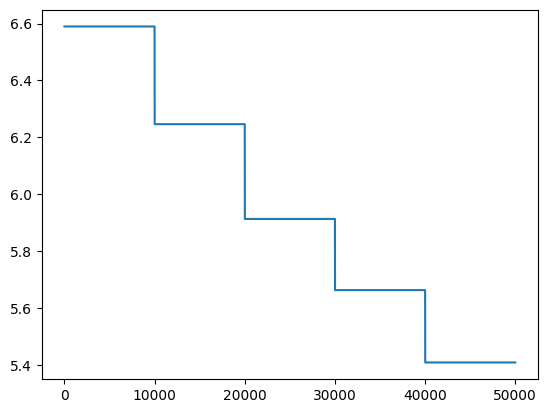

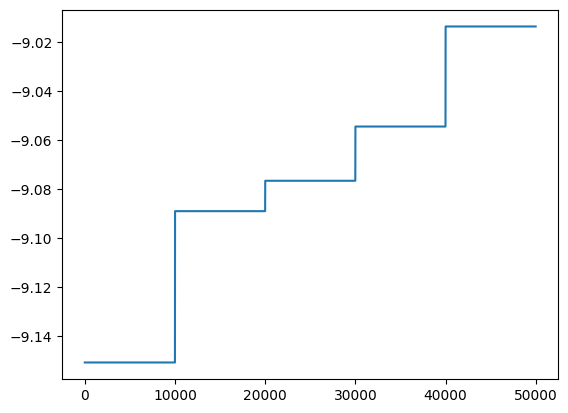

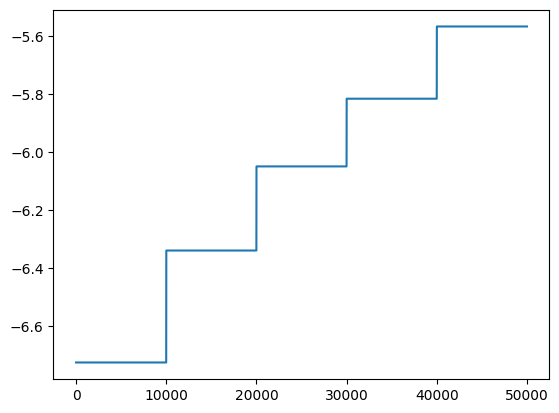

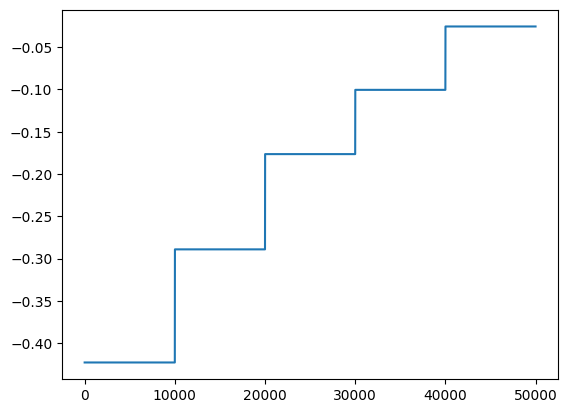

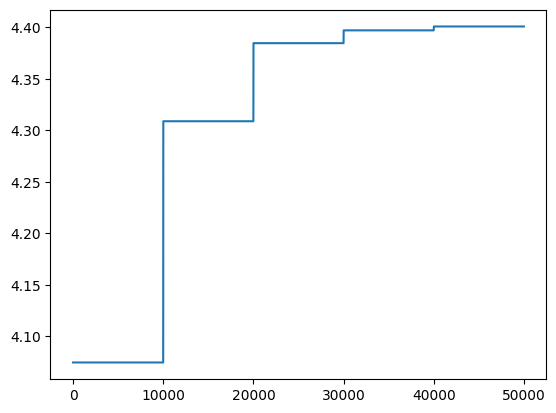

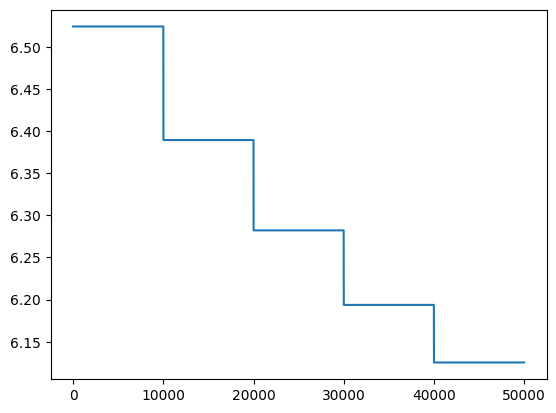

In [ ]:
param_arr = np.array(param_list_epoch).transpose()
for pa in param_arr:
    plt.plot(range(len(pa)), pa)
    plt.show()

In [ ]:
print(ideal_data[0])

(array([[3.1862059 , 0.06196144],
       [3.5815449 , 3.2716758 ],
       [4.885557  , 6.272745  ],
       [5.698155  , 2.510339  ],
       [2.6882708 , 5.4762034 ],
       [5.157526  , 5.5547433 ],
       [3.0785306 , 0.24630354],
       [4.2526507 , 3.7687037 ]], dtype=float32), tensor([ 5.9492e-06-9.5776e-06j, -6.8696e-06-1.6815e-05j,
        -2.4850e-04-2.5696e-04j, -5.7011e-04+8.1243e-05j,
         7.0076e-06-1.2218e-06j,  5.0308e-06-1.0296e-05j,
         1.6604e-05-2.2491e-04j, -2.7769e-04-2.3428e-04j,
        -4.7355e-05+1.2150e-05j, -2.8917e-05+7.3258e-05j,
         7.5159e-06+1.5500e-03j,  2.0290e-03+1.4554e-03j,
        -2.5609e-05-1.7191e-05j, -4.6634e-05+1.7154e-05j,
        -7.2654e-04+6.5451e-04j,  1.6696e-04+1.5665e-03j,
        -3.3858e-06+2.5586e-07j, -2.8670e-06+4.6585e-06j,
        -1.8306e-05+1.0608e-04j,  1.2108e-04+1.2416e-04j,
        -1.5425e-06-1.4865e-06j, -3.3973e-06+6.0682e-07j,
        -5.7631e-05+3.5936e-05j, -7.6033e-06+1.0915e-04j,
         1.1370e-05+9.